In [34]:
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import callbacks
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout
from sklearn.model_selection import KFold
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
tf.config.set_visible_devices([], 'GPU')

In [35]:
df = pd.read_csv("data/modified_0420.csv")
x_train = df.drop(columns=['loan_status','Unnamed: 0'])
y_train = df['loan_status']

In [36]:
nan_indices = np.isnan(x_train).any(axis=1)
x_train = x_train[~nan_indices]
y_train = y_train[~nan_indices]

In [37]:
x_train.shape

(1131682, 89)

In [22]:
# minmax scaler 찾아보기
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)

[0.15351255 0.23887498 0.29132949 0.33460378 0.37342152 0.40992361
 0.44018213 0.46830687 0.49304401 0.51586528 0.53721772 0.55750293
 0.57607956 0.59350761 0.60844465 0.62254463 0.63602833 0.64925373
 0.66216411 0.67429034 0.68602493 0.69753601 0.70896553 0.7203637
 0.73171759 0.74305794 0.75434201 0.76561303 0.77685392 0.78806636
 0.79920845 0.81031344 0.8213071  0.83225873 0.843079   0.85338506
 0.86359883 0.87338488 0.88257324 0.89131271 0.89893998 0.90642617
 0.91346178 0.9200401  0.92612666 0.93178941 0.93700023 0.94206948
 0.9466856  0.95121647 0.95564362 0.95970912 0.96346197 0.96705088
 0.97012257 0.9729337  0.97537772 0.97757369 0.97956607 0.98142723
 0.9830844  0.98459436 0.98608351 0.98749547 0.98884414 0.99014148
 0.99140624 0.99253264 0.99357978 0.99458026 0.99551418 0.99635191
 0.99705684 0.99757707 0.99805306 0.99842364 0.99877569 0.99905902
 0.99931589 0.99949095 0.99965833 0.99977262 0.99987296 0.99993982
 0.99999192 1.         1.         1.         1.        ]


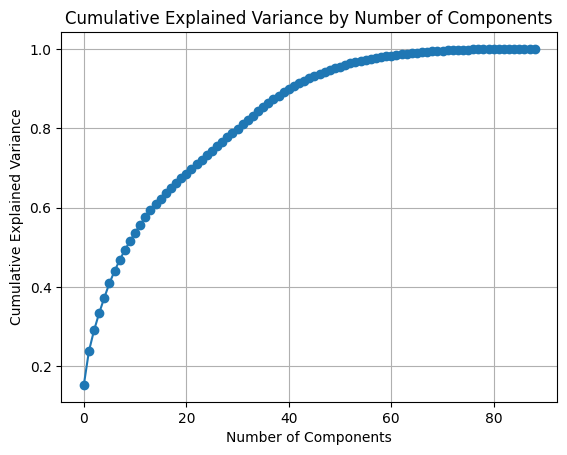

86

In [38]:
def get_n_components_from_pca(scaled_data:pd.DataFrame, threshold:float) -> int:
    pca = PCA()
    pca.fit(scaled_data)
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)
    print(cumulative_explained_variance)
    # 누적 설명 분산 시각화
    plt.plot(cumulative_explained_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by Number of Components')
    plt.grid(True)
    plt.show()
    # 적절한 주성분 개수 선택
    n_components = np.argmax(cumulative_explained_variance >= threshold) + 1
    return n_components
get_n_components_from_pca(X_scaled, 1)

In [24]:
# PCA로 차원 축소
pca = PCA(n_components=86)
X_pca = pca.fit_transform(X_scaled)
x_train = X_pca.astype('float32')
# stratify로 학습에 용이하게 비율 유지
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [25]:
y_train=to_categorical(y_train, 2).astype(int)
y_validation=to_categorical(y_validation, 2).astype(int)
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder()
# y_train = y_train.values
# y_train = encoder.fit_transform(y_train.reshape(-1, 1))

In [26]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

바로 아래 칸은 최적의 hyperparameter를 찾기 위해서 실행하는 칸이므로, 실행할 필요 없습니다.

모델만을 알고싶다면 넘어가세요.

In [27]:
# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

Best average accuracy: 0.8014812111854553

In [28]:
# KerasClassifier을 위한 build_fn 정의 (build_model)
# 신경망 model 생성
def build_model(num_layers, num_nodes, loss):
    # Define and compile the model
    model = keras.Sequential()
    model.add(Dense(num_nodes, input_dim=86, activation='relu'))
    for _ in range(num_layers):
        model.add(Dense(num_nodes, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='Adam', loss=loss, metrics=["accuracy"])
    return model
# KFold validation 사용
# k: n_splits=5
kfold = KFold(random_state=30,
           n_splits=5,
           shuffle=True
          )
model = KerasClassifier(build_fn = build_model)
# model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model)
# 최적 hyperparameter을 찾기위한 gridsearchCV를 위한 parameter
parameters = {
    'batch_size': [1000,5000,10000],
    'epochs': [45,60,100],
    'num_layers': [2, 3],
    'num_nodes': [10, 20, 40],
    'loss':["categorical_crossentropy","sparse_categorical_crossentropy"]
    }
# GridSearchCV 생성
grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           cv = kfold)
early_stopping = EarlyStopping(monitor='loss',min_delta=0.001)
# GridSearchCV fit 시작
grid_search.fit(x_train, y_train, callbacks=[early_stopping])
# 최적의 param
print(f"Best params: {grid_search.best_params_}")
# 최적의 param일 경우 최적의 accuracy
print(f"Best average accuracy: {grid_search.best_score_}")

Epoch 1/45
725/725 [==============================] - 3s 3ms/step - loss: 0.4818 - accuracy: 0.7952
Epoch 2/45
182/182 [==============================] - 0s 1ms/step - loss: 0.4581 - accuracy: 0.7986
Epoch 1/45
725/725 [==============================] - 2s 3ms/step - loss: 0.4905 - accuracy: 0.7897
Epoch 2/45
182/182 [==============================] - 0s 1ms/step - loss: 0.4590 - accuracy: 0.7968
Epoch 1/45
725/725 [==============================] - 2s 3ms/step - loss: 0.4982 - accuracy: 0.7855
Epoch 2/45
182/182 [==============================] - 0s 1ms/step - loss: 0.4575 - accuracy: 0.7999
Epoch 1/45
725/725 [==============================] - 2s 3ms/step - loss: 0.4884 - accuracy: 0.7915
Epoch 2/45
182/182 [==============================] - 0s 1ms/step - loss: 0.4570 - accuracy: 0.7989
Epoch 1/45
725/725 [==============================] - 2s 3ms/step - loss: 0.4937 - accuracy: 0.7929
Epoch 2/45
182/182 [==============================] - 0s 1ms/step - loss: 0.4558 - accuracy: 0.7999


In [12]:
# grid_search를 수행했을 경우의 각각의 결과
result = grid_search.cv_results_
result

{'mean_fit_time': array([3.75789332, 4.30777836, 4.33999658, 5.5541275 , 5.11061521,
        6.16098056, 1.06994209, 0.63555026, 0.81090918, 0.7712852 ,
        0.68296213, 0.72728543, 4.50320058, 4.00286765, 4.94313641,
        5.41075573, 4.64401445, 5.67322831, 0.577356  , 0.52926874,
        0.55411096, 0.6682375 , 0.57839413, 0.66581478, 4.41535201,
        4.13779402, 5.41786242, 5.87651119, 4.68887033, 6.29433832,
        0.56359096, 0.6403368 , 0.5700037 , 0.63589191, 0.68769994,
        0.61517172, 5.39195166, 4.64282236, 5.5790482 , 6.40150347,
        5.49485493, 6.54536386, 0.63533525, 0.56839733, 0.63380957,
        0.61277924, 0.61797104, 0.69280815, 2.3939703 , 2.55472102,
        3.02915616, 2.83349409, 2.92165227, 3.80169635, 0.57504468,
        0.64414258, 0.57909603, 0.68418126, 0.62514095, 0.62413435,
        2.6084971 , 2.80952044, 3.35774288, 2.88276944, 3.37500687,
        3.88307576, 0.63523531, 0.5669229 , 0.64589343, 0.62757993,
        0.63945289, 0.70597734,

아래는 위의 모델을 생성한 결과를 바탕으로 hyperparameter를 설정한 모델입니다.

## 최적 모델(without EarlyStopping)
- avg accuracy: 0.8006682634353638
- avg F1-score: 0.800676167011261
- avg recall: 0.8006762623786926
- avg precision: 0.8006762623786926

In [29]:
best_params = grid_search.best_params_
best_params

{'batch_size': 1000,
 'epochs': 100,
 'loss': 'categorical_crossentropy',
 'num_layers': 2,
 'num_nodes': 40}

In [30]:
# # 최고의 파라미터 : {'batch_size': 1000, 'epochs': 100, 'loss': 'categorical_crossentropy', 'num_layers': 2, 'num_nodes': 40}
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []
best_params = grid_search.best_params_

# 신경망층 설계
model = keras.Sequential()
model.add(Dense(best_params['num_nodes'], input_dim=86, activation='relu'))
for _ in range(best_params['num_layers']):
    model.add(Dense(best_params['num_nodes'], activation='relu'))
    model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(2, activation='softmax'))
# 모델 컴파일
model.compile(loss=best_params['loss'], optimizer='Adam', metrics=["accuracy", f1_score, recall, precision])
# KFoldvalidation 사용함(k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=30)
early_stopping = EarlyStopping(monitor='loss',min_delta=0.001)
for train_index, val_index in kf.split(x_train, y_train):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]
    # 모델 학습
    model.fit(X_train_fold, Y_train_fold, 
              batch_size=best_params['batch_size'], 
              epochs=best_params['epochs'], 
              verbose=1)

    # 모델 validation
    valid_loss, valid_acc, valid_f1, valid_recall, valid_precision = model.evaluate(X_val_fold, Y_val_fold)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    valid_recalls.append(valid_recall)
    valid_precisions.append(valid_precision)
    print("===================================")
    print("Validation accuracy:", valid_acc)
    print("Validation F1-score:", valid_f1)
    print("Validation recall:", valid_recall)
    print("Validation precision:", valid_precision)
print("###################################")
print("avg Validation accuracy:", np.mean(valid_accs))
print("avg Validation F1-score:", np.mean(valid_f1s))
print("avg Validation recall:", np.mean(valid_recalls))
print("avg Validation precision:", np.mean(valid_precisions))

Epoch 1/100
725/725 [==============================] - 5s 7ms/step - loss: 0.4657 - accuracy: 0.7983 - f1_score: 0.7983 - recall: 0.7983 - precision: 0.7983
Epoch 2/100
725/725 [==============================] - 5s 7ms/step - loss: 0.4562 - accuracy: 0.8002 - f1_score: 0.8002 - recall: 0.8002 - precision: 0.8002
Epoch 3/100
725/725 [==============================] - 5s 7ms/step - loss: 0.4546 - accuracy: 0.8005 - f1_score: 0.8005 - recall: 0.8005 - precision: 0.8005
Epoch 4/100
725/725 [==============================] - 6s 8ms/step - loss: 0.4535 - accuracy: 0.8009 - f1_score: 0.8009 - recall: 0.8009 - precision: 0.8009
Epoch 5/100
725/725 [==============================] - 5s 8ms/step - loss: 0.4527 - accuracy: 0.8014 - f1_score: 0.8014 - recall: 0.8014 - precision: 0.8014
Epoch 6/100
725/725 [==============================] - 5s 7ms/step - loss: 0.4521 - accuracy: 0.8017 - f1_score: 0.8016 - recall: 0.8016 - precision: 0.8016
Epoch 7/100
725/725 [==============================] - 5s 

In [31]:
model.save('dnn_models/pca1_feature86/without_earlystopping_0421.h5')

## 최적 model(with EarlyStopping)
### earlystopping: min_delta was 0.001
- avg accuracy: 0.8006682634353638
- avg F1-score: 0.800676167011261
- avg recall: 0.8006762623786926
- avg precision: 0.8006762623786926

### earlystopping: min_delta was 0.0001
- avg accuracy: 0.80015869140625
- avg F1-score: 0.8001592040061951
- avg recall: 0.8001593112945556
- avg precision: 0.8001593112945556

In [32]:
# # 최고의 파라미터 : {'batch_size': 1000, 'epochs': 100, 'loss': 'categorical_crossentropy', 'num_layers': 2, 'num_nodes': 40}
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []
best_params = grid_search.best_params_

# 신경망층 설계
model = keras.Sequential()
model.add(Dense(best_params['num_nodes'], input_dim=86, activation='relu'))
for _ in range(best_params['num_layers']):
    model.add(Dense(best_params['num_nodes'], activation='relu'))
    model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(2, activation='softmax'))
# 모델 컴파일
model.compile(loss=best_params['loss'], optimizer='Adam', metrics=["accuracy", f1_score, recall, precision])
# KFoldvalidation 사용함(k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=30)
early_stopping = EarlyStopping(monitor='loss',min_delta=0.001)
for train_index, val_index in kf.split(x_train, y_train):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]
    # 모델 학습
    model.fit(X_train_fold, Y_train_fold, 
              batch_size=best_params['batch_size'], 
              epochs=best_params['epochs'], 
              verbose=1, 
              callbacks=[early_stopping])

    # 모델 validation
    valid_loss, valid_acc, valid_f1, valid_recall, valid_precision = model.evaluate(X_val_fold, Y_val_fold)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    valid_recalls.append(valid_recall)
    valid_precisions.append(valid_precision)
    print("===================================")
    print("Validation accuracy:", valid_acc)
    print("Validation F1-score:", valid_f1)
    print("Validation recall:", valid_recall)
    print("Validation precision:", valid_precision)
print("###################################")
print("avg Validation accuracy:", np.mean(valid_accs))
print("avg Validation F1-score:", np.mean(valid_f1s))
print("avg Validation recall:", np.mean(valid_recalls))
print("avg Validation precision:", np.mean(valid_precisions))
model.save('dnn_models/pca1_feature86/with_earlystopping_001_0421.h5')

Epoch 1/100
725/725 [==============================] - 5s 7ms/step - loss: 0.4717 - accuracy: 0.7955 - f1_score: 0.7955 - recall: 0.7955 - precision: 0.7955
Epoch 2/100
5659/5659 [==============================] - 6s 1ms/step - loss: 0.4542 - accuracy: 0.8018 - f1_score: 0.8018 - recall: 0.8018 - precision: 0.8018
Validation accuracy: 0.8017992973327637
Validation F1-score: 0.8018038868904114
Validation recall: 0.8018039464950562
Validation precision: 0.8018039464950562
Epoch 1/100
725/725 [==============================] - 5s 7ms/step - loss: 0.4552 - accuracy: 0.8010 - f1_score: 0.8010 - recall: 0.8010 - precision: 0.8010
Epoch 2/100
5659/5659 [==============================] - 7s 1ms/step - loss: 0.4534 - accuracy: 0.7994 - f1_score: 0.7994 - recall: 0.7994 - precision: 0.7994
Validation accuracy: 0.7993582487106323
Validation F1-score: 0.7993549704551697
Validation recall: 0.7993550896644592
Validation precision: 0.7993550896644592
Epoch 1/100
725/725 [=============================

In [33]:
# # 최고의 파라미터 : {'batch_size': 1000, 'epochs': 100, 'loss': 'categorical_crossentropy', 'num_layers': 2, 'num_nodes': 40}
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []
best_params = grid_search.best_params_

# 신경망층 설계
model = keras.Sequential()
model.add(Dense(best_params['num_nodes'], input_dim=86, activation='relu'))
for _ in range(best_params['num_layers']):
    model.add(Dense(best_params['num_nodes'], activation='relu'))
    model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(2, activation='softmax'))
# 모델 컴파일
model.compile(loss=best_params['loss'], optimizer='Adam', metrics=["accuracy", f1_score, recall, precision])
# KFoldvalidation 사용함(k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=30)
early_stopping = EarlyStopping(monitor='loss',min_delta=0.0001)
for train_index, val_index in kf.split(x_train, y_train):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]
    # 모델 학습
    model.fit(X_train_fold, Y_train_fold, 
              batch_size=best_params['batch_size'], 
              epochs=best_params['epochs'], 
              verbose=1, 
              callbacks=[early_stopping])

    # 모델 valdation
    valid_loss, valid_acc, valid_f1, valid_recall, valid_precision = model.evaluate(X_val_fold, Y_val_fold)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    valid_recalls.append(valid_recall)
    valid_precisions.append(valid_precision)
    print("===================================")
    print("Validation accuracy:", valid_acc)
    print("Validation F1-score:", valid_f1)
    print("Validation recall:", valid_recall)
    print("Validation precision:", valid_precision)
print("###################################")
print("avg Validation accuracy:", np.mean(valid_accs))
print("avg Validation F1-score:", np.mean(valid_f1s))
print("avg Validation recall:", np.mean(valid_recalls))
print("avg Validation precision:", np.mean(valid_precisions))
model.save('dnn_models/pca1_feature86/with_earlystopping_0001_0421.h5')

Epoch 1/100
725/725 [==============================] - 5s 7ms/step - loss: 0.4692 - accuracy: 0.7972 - f1_score: 0.7972 - recall: 0.7972 - precision: 0.7972
Epoch 2/100
5659/5659 [==============================] - 5s 929us/step - loss: 0.4546 - accuracy: 0.8022 - f1_score: 0.8022 - recall: 0.8022 - precision: 0.8022
Validation accuracy: 0.8022080063819885
Validation F1-score: 0.8022125363349915
Validation recall: 0.8022125959396362
Validation precision: 0.8022125959396362
Epoch 1/100
725/725 [==============================] - 5s 7ms/step - loss: 0.4549 - accuracy: 0.8011 - f1_score: 0.8011 - recall: 0.8011 - precision: 0.8011
Epoch 2/100
5659/5659 [==============================] - 5s 945us/step - loss: 0.4526 - accuracy: 0.8007 - f1_score: 0.8007 - recall: 0.8007 - precision: 0.8007
Validation accuracy: 0.800727903842926
Validation F1-score: 0.800724446773529
Validation recall: 0.8007245659828186
Validation precision: 0.8007245659828186
Epoch 1/100
725/725 [===========================